## Isentropic Vortex in 2D

This example is taken from **Spiegel et al. (2015)**, namely Section *IV.A.1*. Hence, the exact solution is based on the Gaussian pulse
$$
\Omega = \beta e^{f},
$$
where $f(x,y) = -\frac{1}{2\sigma^2} \Big( r^2/ R^2 \Big)$, with $r^2 = (x-x_c)^2 + (y-y_c)^2$ and $(x_c, y_c)$ correspond to the initial location of the pulse. Using this function, we define the perturbations to the velocity and temperature as
$$
\delta u = - \big( y/R \big) \Omega, \qquad
\delta v =   \big( x/R \big) \Omega, \qquad
\delta T = - \big( \overline{\gamma}/2 \big) \Omega^2,
$$
with $\overline{\gamma} = \gamma - 1$ and the specific heat ratio is taken as $\gamma = 1.4$.

Afterwards, these perturbations along with an isentropic flow assumption ($\delta s = 0$, where $s = p/\rho^\gamma$), we generate the analytic solution. In primitive variables, this reads
$$
\rho = \big( 1 + \delta T\big)^{1/\overline{\gamma}},\qquad
u = M_\infty \cos \alpha + \delta u,\qquad 
v = M_\infty \sin \alpha + \delta v,\qquad
p = \rho^{\gamma}/\gamma,
$$
where $M_\infty$ is the mean Mach number and $\alpha$ is the flow angle, taken with respect to the $x$-axis.

Following d'Alembert's solution, the above analytic solution at any given time is simply the shift of the initial condition ($t = t_0$). This can be represented by substituting the initial coordinates $x$ and $y$ with
$$
x(t) = x - u_\infty t,\qquad
y(t) = y - v_\infty t,
$$
where $(u_\infty, v_\infty)$ is the mean velocity, obtained from the Mach number and flow direction via $u_\infty = M_\infty \cos \alpha$ and $v_\infty = M_\infty \sin \alpha$.

For this specific example, the parameters used are: a mean Mach number of $M_\infty = 0.5$, a Gaussian amplitude of $\beta = M_\infty \frac{5 \sqrt{2}}{4 \pi} e^{1/2}$ with a characteristic width of $R = 1$,  a flow angle of $\alpha = 45^{\circ}$ on a grid $\boldsymbol{x} \in [-5,+5]^2$ with an initial pulse center situated at $(x_c, y_c) = (0, 0)$. The total duration of this simulation is taken as $t \in [0,5]$. Note, all variables are non-dimensional, by definition.

[1] **Spiegel, Seth C., H. T. Huynh, and James R. DeBonis.**  
"A Survey of the Isentropic Euler Vortex Problem Using High-Order Methods."  
*22nd AIAA Computational Fluid Dynamics Conference*, 2015.


In [1]:
# Import preliminary modules.
from dream import *
from dream.compressible import Initial, CompressibleFlowSolver, flowfields
import ngsolve as ngs 

In [2]:
# Define the grid.
from netgen.occ import OCCGeometry, WorkPlane
from netgen.meshing import IdentificationType

def CreateSimpleGrid(ne, lx, ly):

    # Select a common element size.
    h0 = min( lx, ly )/float(ne)

    # Generate a simple rectangular geometry.
    domain = WorkPlane().RectangleC(lx, ly).Face()

    # Assign the name of the internal solution in the domain.
    domain.name = 'internal'

    # For convenience, extract and name each of the edges consistently.
    bottom = domain.edges[0]; bottom.name = 'bottom'
    right  = domain.edges[1]; right.name  = 'right'
    top    = domain.edges[2]; top.name    = 'top'
    left   = domain.edges[3]; left.name   = 'left'

    # Pair the boundaries in each direction: vertical and horizontal.
    bottom.Identify(top, "ydir", IdentificationType.PERIODIC)
    right.Identify(left, "xdir", IdentificationType.PERIODIC)

    # Initialize a rectangular 2D geometry.
    geo = OCCGeometry(domain, dim=2)

    # Discretize the domain.
    mesh = ngs.Mesh(geo.GenerateMesh(maxh=h0, quad_dominated=True))

    # Return our fancy grid.
    return mesh


In [3]:
# Generate the grid.

# Number of elements per dimension.
ne = 10

# Dimension of the rectangular domain.
lx = 10.0 
ly = 10.0 

# Generate a simple grid.
mesh = CreateSimpleGrid(ne, lx, ly)

# Message output detail from netgen.
ngs.ngsglobals.msg_level = 0 
ngs.SetNumThreads(4)

In [4]:
# Class containing all the parameters to define an isentropic vortex. 
class IsentropicVortexParam:
    def __init__(self, cfg):
       
        # Center of the vortex, assumed at the center of the domain. 
        # Currently, this assumes that the domain is: [0,lx],[0,ly].       
        self.x0     = 0.0
        self.y0     = 0.0

        # Vortex parameters, found in Spiegel et al. (2015). 
        self.theta  = 45.0 # flow angle [deg]. 
        self.Tinf   = 1.0  # background temperature.
        self.Pinf   = 1.0  # background pressure.
        self.Rinf   = 1.0  # background density.
        self.Minf   = 0.5  # background Mach.
        self.sigma  = 1.0  # Perturbation strength.
        self.Rv     = 1.0  # Perturbation width.
        
        # Scaling for the maximum strength of the perturbation.
        self.beta   = self.Minf*ngs.exp(0.5)*5.0*ngs.sqrt(2.0)/(4.0*ngs.pi)

        # Convert the angle from degrees to radians.
        self.theta *= ngs.pi/180.0

        # Deduce the background mean velocity.
        self.uinf   = self.Minf*ngs.cos( self.theta )
        self.vinf   = self.Minf*ngs.sin( self.theta )

        # Store gamma here, so we do not pass it around constantly.
        self.gamma  = cfg.equation_of_state.heat_capacity_ratio


# Function that defines the analytic solution.
def InitialCondition(cfg):
  
    # Extract the starting time.
    t0 = cfg.time.timer.interval[0]

    # Return the analytic solution at time: t0.
    return AnalyticSolution(cfg, t0)


# Function that creates a time-dependant analytic solution.
def AnalyticSolution(cfg, t):

    # Extract the vortex parameters.
    vparam = IsentropicVortexParam(cfg)

    # Generate an array of 4x3 vortices. If you need something different, modify it.
    # NOTE, in this case, the 4x3 array of vortices assumes:
    #  1) flow aligned in (+ve) x-direction.
    #  2) simulation is done for only 1 period: tf = lx/uInf.
    fn = ngs.CF(())
    for i in range(-2,2):
        for j in range(-1,2):
            fn += GeneratePerturbation(vparam, t, i, j)

    # For convenience, extract the perturbations explicitly.
    dT = fn[0]; du = fn[1]; dv = fn[2]

    # Extract the required parameters to construct the actual variables.
    gamma  = vparam.gamma
    uinf   = vparam.uinf
    vinf   = vparam.vinf

    # Abbreviations involving gamma.
    gm1    =  gamma - 1.0
    ovg    =  1.0/gamma
    ovgm1  =  1.0/gm1
    govgm1 =  gamma*ovgm1

    # Define the primitive variables, by superimposing the perturbations on a background state.
    r = (1.0 + dT)**ovgm1
    u = uinf + du
    v = vinf + dv
    p = ovg*(1.0 + dT)**govgm1

    # Return the analytic expression of the vortex.
    return flowfields( rho=r, u=(u, v), p=p )


# Function that generates a single isentropic perturbations in the velocity and temperature.
# Here, (ni,nj) are the integers for the multiple of (lx,ly)
# distances between the leading/trailing vortices.
def GeneratePerturbation(vparam, t, ni, nj):

    # For convenience, extract the information of the vortex.
    theta = vparam.theta
    Tinf  = vparam.Tinf
    Pinf  = vparam.Pinf
    Rinf  = vparam.Rinf
    Minf  = vparam.Minf
    sigma = vparam.sigma
    Rv    = vparam.Rv
    beta  = vparam.beta
    gamma = vparam.gamma
    x0    = vparam.x0
    y0    = vparam.y0
    uinf  = vparam.uinf
    vinf  = vparam.vinf

    # Center of the pulse.
    xc = x0 + ni*lx
    yc = y0 + nj*ly

    # Time-dependent pulse center.
    xt = (ngs.x-xc) - uinf*t
    yt = (ngs.y-yc) - vinf*t

    # Abbreviations involving gamma.
    gm1    =  gamma - 1.0
    ovg    =  1.0/gamma
    ovgm1  =  1.0/gm1
    govgm1 =  gamma*ovgm1
    ovs2   =  1.0/(sigma*sigma)

    # The Gaussian perturbation function.
    ovRv   =  1.0/Rv
    f      = -0.5*ovs2*( (xt/Rv)**2 + (yt/Rv)**2 )
    Omega  =  beta*ngs.exp(f)

    # Velocity and temperature perturbations.
    du = -ovRv*yt*Omega
    dv =  ovRv*xt*Omega
    dT = -0.5*gm1*Omega**2

    # Return the Perturbations.
    return ngs.CF( (dT, du, dv) )

In [5]:
# Solver configuration: Compressible (inviscid) flow.
cfg = CompressibleFlowSolver(mesh)

cfg.dynamic_viscosity = "inviscid"
cfg.equation_of_state = "ideal"
cfg.equation_of_state.heat_capacity_ratio = 1.4
cfg.scaling = "acoustic"
cfg.mach_number = 0.0

cfg.riemann_solver = "lax_friedrich"
cfg.fem = "conservative"
cfg.fem.order = 0
cfg.fem.method = "hdg" # NOTE, by default, HDG is used.

cfg.time = "transient"
cfg.fem.scheme = "implicit_euler"
cfg.time.timer.interval = (0.0, 5.0)
cfg.time.timer.step = 0.25

cfg.linear_solver = "pardiso"
cfg.nonlinear_solver = "pardiso"
cfg.nonlinear_solver.method = "newton"
cfg.nonlinear_solver.method.damping_factor = 1
cfg.nonlinear_solver.max_iterations = 10
cfg.nonlinear_solver.convergence_criterion = 1e-10

cfg.optimizations.static_condensation = True  # NOTE, by default, condensation is turned on.
cfg.optimizations.compile.realcompile = False

Uic = InitialCondition(cfg)

cfg.bcs['left|right'] = "periodic"
cfg.bcs['top|bottom'] = "periodic"
cfg.dcs['internal'] = Initial(fields=Uic)

In [6]:
# Decorator for the actual simulation.
import numpy as np

# Extract time configuration.
t0, tf = cfg.time.timer.interval
dt = cfg.time.timer.step.Get()
nt = int(round((tf - t0) / dt))

# Abbreviations.
gamma = cfg.equation_of_state.heat_capacity_ratio

# Define a decorator for the isentropic vortex routine.
def isentropic_vortex_routine(label):
    def decorator(func):
        def wrapper(*args, draw_solution=False, **kwargs):

            # By default, assume this is a DG formulation.
            cfg.optimizations.static_condensation = False
            
            # Insert options here.
            func(*args, **kwargs)
            cfg.fem.order = 4

            # In case an HDG formulation is specified, use static condensation.
            if cfg.fem.name == "hdg":
               cfg.optimizations.static_condensation = True
            
            # Allocate the necessary data.
            cfg.initialize()

            # Get a reference to the numerical solution and the analytic solution.
            uh = cfg.get_solution_fields('rho_u')
            ue = AnalyticSolution(cfg, cfg.time.timer.t)

            if draw_solution:
                # cfg.io.draw({"Density": uh.rho})
                # cfg.io.draw({"Mach": cfg.get_local_mach_number(uh)})
                # cfg.io.draw({"Exact[Density]": ue.rho})
                isentropic_deviation = (uh.p/ue.p) * (ue.rho/uh.rho)**gamma - 1.0
                cfg.io.draw({"Deviation[Isentropy]": isentropic_deviation}, min=-0.0001, max=0.0001)
                #cfg.io.draw({"Diff[Density]": (ue.rho - uh.rho)}, min=-0.1, max=0.1)

            # NOTE, uncomment if you want the norm based on magnitude of the momentum.
            mag_rhou_e = ue.rho * ngs.sqrt( ngs.InnerProduct(ue.u, ue.u) )
            mag_rhou_n = ngs.sqrt( ngs.InnerProduct(uh.rho_u, uh.rho_u) )
            # Integration order (for post-processing).
            qorder = 10
    
            # Data for book-keeping information.
            data = np.zeros((nt, 3), dtype=float)
    
            # Time integration loop  (actual simulation).
            for i, t in enumerate(cfg.time.start_solution_routine(True)):
                
                # Compute the L2-norm of the error.
                err_rho = np.sqrt( ngs.Integrate( (ue.rho-uh.rho)**2, mesh, order=qorder) )
                err_mom = np.sqrt( ngs.Integrate( (mag_rhou_e-mag_rhou_n)**2, mesh, order=qorder) )
                
                # Store data: time and error metrics.
                data[i] = [cfg.time.timer.t.Get(), err_rho, err_mom]
            return data
        wrapper.label = label 
        return wrapper
    return decorator

In [7]:
# Specialized routines.

@isentropic_vortex_routine("implicit_euler(hdg)")
def implicit_euler_hdg():
    cfg.fem.method = "hdg"
    cfg.fem.scheme = "implicit_euler"

@isentropic_vortex_routine("bdf2(hdg)")
def bdf2_hdg():
    cfg.fem.method = "hdg"
    cfg.fem.scheme = "bdf2"

@isentropic_vortex_routine("sdirk22(hdg)")
def sdirk22_hdg():
    cfg.fem.method = "hdg"
    cfg.fem.scheme = "sdirk22"

@isentropic_vortex_routine("sdirk33(hdg)")
def sdirk33_hdg():
    cfg.fem.method = "hdg"
    cfg.fem.scheme = "sdirk33"

@isentropic_vortex_routine("imex_rk_ars443(dg)")
def imex_rk_ars443_dg():
    cfg.fem.method = "dg"
    cfg.fem.scheme = "imex_rk_ars443"

@isentropic_vortex_routine("ssprk3(dg)")
def ssprk3_dg():
    cfg.fem.method = "dg"
    cfg.fem.scheme = "ssprk3"

@isentropic_vortex_routine("crk4(dg)")
def crk4_dg():
    cfg.fem.method = "dg"
    cfg.fem.scheme = "crk4"

@isentropic_vortex_routine("explicit_euler(dg)")
def explicit_euler_dg():
    cfg.fem.method = "dg"
    cfg.fem.scheme = "explicit_euler"

In [8]:
# Figure style and properties.
from matplotlib import pyplot as plt

# Assign colors to base method names
method_colors = {
    "implicit_euler": "tab:red",
    "bdf2": "tab:blue",
    "sdirk22": "tab:green",
    "sdirk33": "tab:purple"
}

# Helper function that sets up a generic figure.
def setup_fig(xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xlim(t0, tf)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    return fig,ax


# Helper function that specifies the plot style properties.
def get_plot_style(label, method_colors):
    if label.endswith("(hdg)"):
        base_name = label.replace("(hdg)", "").strip()
        linestyle = "-"
        marker = 'o'
    elif label.endswith("(dg)"):
        base_name = label.replace("(dg)", "").strip()
        linestyle = "--"
        marker = '^'
    else:
        base_name = label.strip()
        linestyle = ":" 
        marker = '.'

    color = method_colors.get(base_name, "black")

    return {
        "label": label,
        "linestyle": linestyle,
        "marker": marker,
        "markersize": 8,
        "markevery": 50,
        "color": color
    }


Running implicit_euler(hdg)...


WebGuiDocuWidget(value={'render_data': 'render_data_6.json', 'preview': 'preview_6.png'})

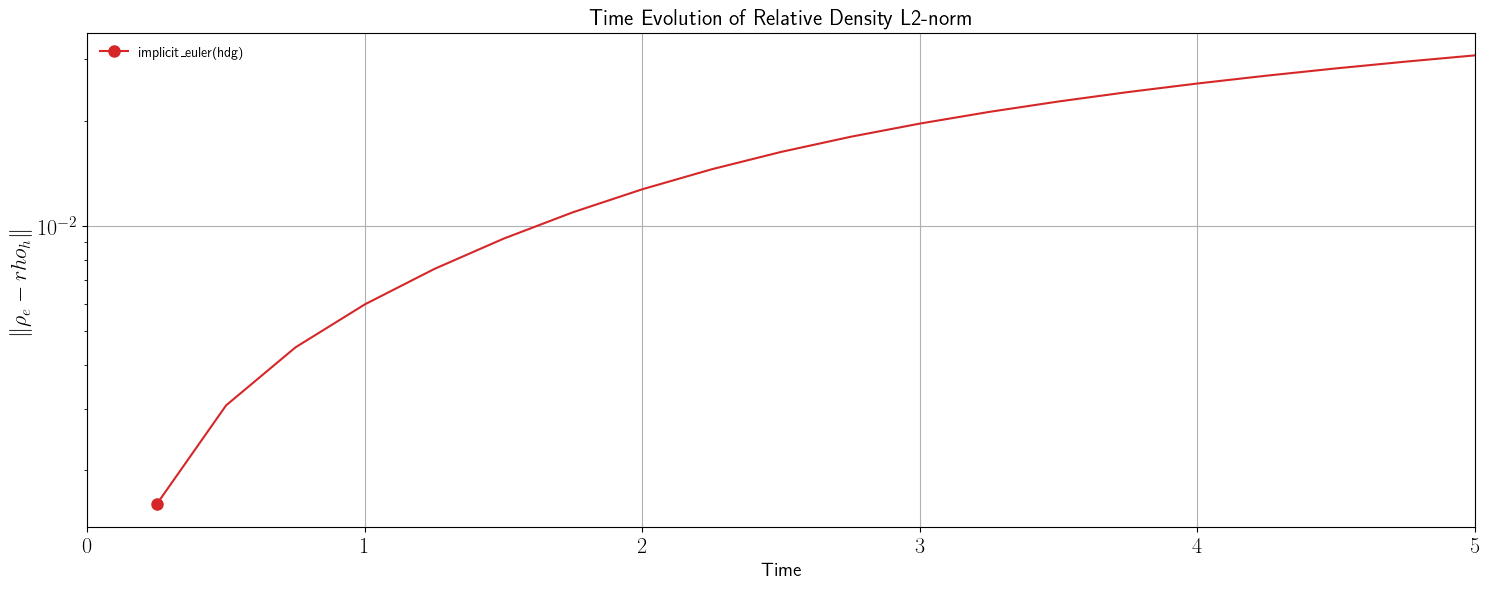

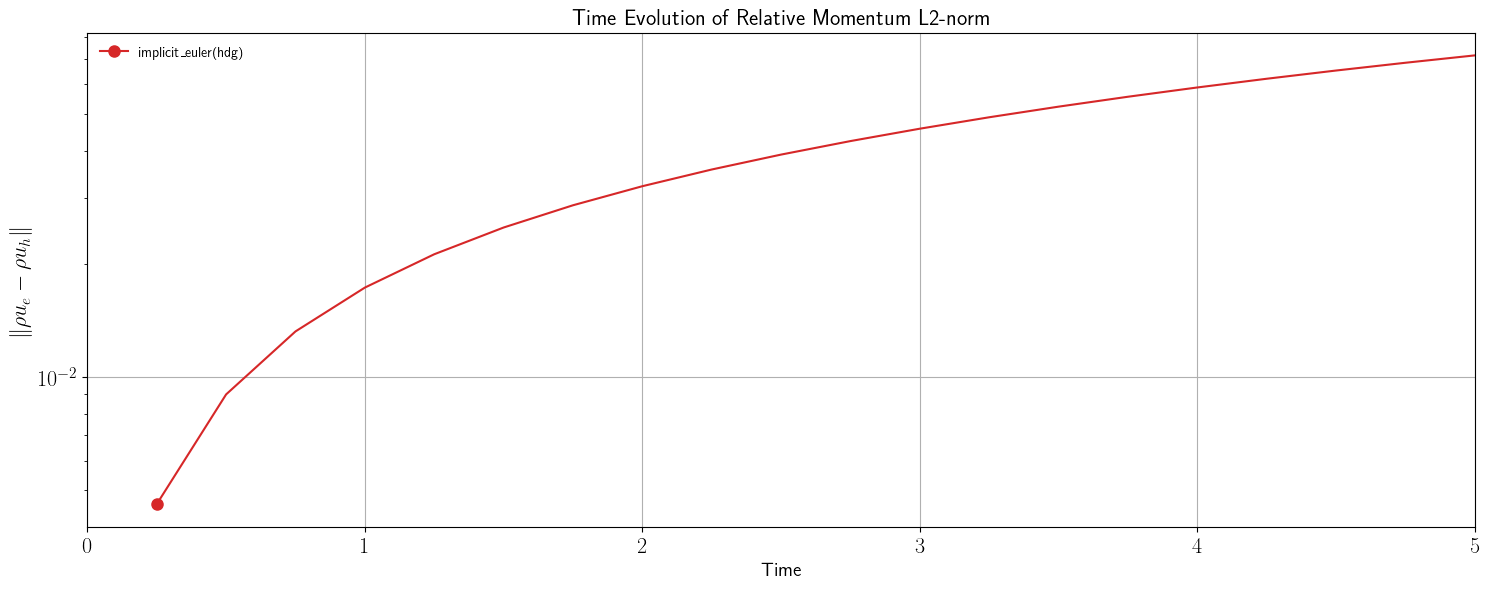

In [9]:
# Run simulation(s).
routines = [implicit_euler_hdg]

# Figure 1: logarithmic plot of the relative error in the L2-norm: density.
fig1, ax1 = setup_fig("Time", r"$\| \rho_e - rho_h \|$", r"Time Evolution of Relative Density L2-norm")

# Figure 2: logarithmic plot of the relative error in the L2-norm: magnitude of momentum.
fig2, ax2 = setup_fig("Time", r"$\| \rho u_e - \rho u_h \|$", r"Time Evolution of Relative Momentum L2-norm")

# Run each simulation.
for routine in routines:
    print(f"Running {routine.label}...")
    data = routine(draw_solution=True)
    style = get_plot_style(routine.label, method_colors)

    ax1.semilogy(data[:, 0], data[:, 1], **style)
    ax2.semilogy(data[:, 0], data[:, 2], **style)


# Final touches.
ax1.legend(loc="upper left", frameon=False)
ax2.legend(loc="upper left", frameon=False)
fig1.tight_layout()
fig2.tight_layout()
plt.show()